In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask
from rasterio.plot import show
import dvc.api
from tqdm import tqdm
import re
import json
import glob
from itertools import chain


params = dvc.api.params_show()

# Load Nutzungflächen from Zürich

In [2]:
gdf_zh = gpd.read_file("./data/ZH_2019_LW_NUTZUNGSFLAECHEN_F.shp")

gdf_zh = gdf_zh.rename(columns = {
    'NUTZUNGSCO': 'lnf_code',
    'GIS_ID': 'zh_id'
    })
gdf_zh['lnf_code'] = gdf_zh['lnf_code'].astype(int)
gdf_zh = gdf_zh[['zh_id', 'lnf_code', 'geometry']]

# Load Nutzungflächen from Thurgau

In [3]:
gdf_tg = gpd.read_file("./data/TG_2019_Nutzungsflaechen_2019.gpkg")
gdf_tg = gdf_tg.rename(columns = {
    'identifikator': 'tg_id'
    })
gdf_tg['lnf_code'] = gdf_tg['lnf_code'].astype(int)
gdf_tg = gdf_tg[['tg_id', 'lnf_code', 'geometry']]

# Filter duplicates

There are certian fields inside the canton's datasets that aren't part of that canton and overlapt with the other canton's dataset. We need to filter these out.

To do this we will use [georef-switzerland-kanton@public](https://data.opendatasoft.com/explore/dataset/georef-switzerland-kanton%40public/information) by "Public by Opendatasoft" to extract the canton's boundaries and filter out the fields that lie outside the cantons.

In [4]:
gdf_cantons = gpd.read_file("./data/georef-switzerland-kanton@public.geojson")
gdf_cantons['kan_name']  = gdf_cantons['kan_name'].str[0]


# Merge the two datasets

In [5]:
gdf = pd.concat([gdf_zh, gdf_tg])

# create a new column with the row number as index, such that we can identify the fields in the labels
gdf = gdf.reset_index()

In [6]:
gdf.head()

index   zh_id  lnf_code                                           geometry  \
0      0  264916       613  POLYGON ((2704690.808 1251701.199, 2704691.436...   
1      1  328581       613  POLYGON ((2704517.958 1242488.970, 2704530.541...   
2      2  266952       613  POLYGON ((2704608.023 1244765.418, 2704602.857...   
3      3  263382       611  POLYGON ((2704711.761 1255889.224, 2704713.251...   
4      4  329369       852  MULTIPOLYGON (((2704617.190 1243385.867, 27046...   

  tg_id  
0   NaN  
1   NaN  
2   NaN  
3   NaN  
4   NaN

We only keep the lnf_code, geometry and id/index columns.

### load satellite image 
to copy the width, heigh, crs and transform such that they'll be the same in the end.

In [7]:
red_files = glob.glob(f"{params['paths']['satellite']}/*_red.tif")
with rasterio.open(red_files[0]) as src:
    width = src.width
    height = src.height
    transform = src.transform
    crs = src.crs

### Load zueri-crop labels to get the same integers for the labels

In [8]:
if params['label_hierarchy_definition'] == 'zueri_crop':
    labels_zueri_crop = pd.read_csv("./data/labels_hierarchy.csv")
elif params['label_hierarchy_definition'] == 'seasonality':
    labels_zueri_crop = pd.read_csv("./data/labels_hierarchy_seasonality.csv")
else:
    raise ValueError(f"Unknown label_hierarchy_definition: {params['label_hierarchy_definition']}")

labels_zueri_crop['lnf_codes'] = labels_zueri_crop['lnf_codes'].apply(lambda x: [int(i) for i in re.findall(r'\d+', x)])
labels_zueri_crop = labels_zueri_crop.reset_index()

# add 1 to the index to match the field number in the labels
labels_zueri_crop['index'] = labels_zueri_crop['index'] + 1
labels_zueri_crop.head()

index      tier_1       tier_2            tier_3       tier_4  pixel_count  \
0      1  Vegetation    Grassland            Meadow       Meadow      3249831   
1      2  Vegetation  Field crops  SmallGrainCereal  WinterWheat       837126   
2      3  Vegetation  Field crops  LargeGrainCereal        Maize       809566   
3      4  Vegetation    Grassland           Pasture      Pasture       505770   
4      5  Vegetation  Field crops  BroadLeafRowCrop  Sugar_beets       295998   

                                          label_ids  \
0  ['58', '59', '60', '61', '62', '66', '67', '71']   
1                                            ['10']   
2                                 ['7', '14', '15']   
3                   ['63', '64', '65', '68', '123']   
4                                            ['16']   

                                  lnf_codes  \
0  [601, 602, 611, 612, 613, 621, 622, 634]   
1                                     [513]   
2                           [508, 519, 521]   
3                 [616, 617, 618, 625, 930]   
4                                     [522]   

                                          label_slug  
0                 Vegetation_Grassland_Meadow_Meadow  
1  Vegetation_Field crops_SmallGrainCereal_Winter...  
2      Vegetation_Field crops_LargeGrainCereal_Maize  
3               Vegetation_Grassland_Pasture_Pasture  
4  Vegetation_Field crops_BroadLeafRowCrop_Sugar_...

We need to ensure, that all Labels present in the Zürich and Thurgau dataset are mapped to an integer by the zueri-crop labels.

In [9]:
index_to_lnf_codes = dict(zip(labels_zueri_crop['index'], labels_zueri_crop['lnf_codes']))
# reverse the dictionary
lnf_code_mapping = {v: k for k, v_list in index_to_lnf_codes.items() for v in v_list}
lnf_code_mapping

{601: 1,
 602: 1,
 611: 1,
 612: 1,
 613: 1,
 621: 1,
 622: 1,
 634: 1,
 513: 2,
 508: 3,
 519: 3,
 521: 3,
 616: 4,
 617: 4,
 618: 4,
 625: 4,
 930: 4,
 522: 5,
 502: 6,
 527: 7,
 591: 7,
 545: 8,
 546: 8,
 524: 9,
 525: 9,
 505: 10,
 507: 10,
 531: 11,
 592: 11,
 701: 12,
 717: 12,
 722: 12,
 735: 12,
 516: 13,
 556: 14,
 557: 14,
 852: 15,
 857: 15,
 858: 15,
 702: 16,
 528: 17,
 537: 18,
 504: 19,
 551: 20,
 705: 20,
 511: 21,
 536: 22,
 512: 23,
 514: 24,
 712: 25,
 713: 25,
 704: 26,
 569: 27,
 542: 28,
 549: 28,
 506: 29,
 515: 29,
 543: 29,
 547: 30,
 703: 31,
 501: 32,
 555: 33,
 572: 33,
 908: 33,
 901: 34,
 534: 35,
 544: 35,
 631: 36,
 539: 37,
 541: 38,
 548: 39,
 535: 40,
 526: 41,
 708: 42,
 523: 43,
 902: 44,
 538: 45,
 573: 46,
 909: 47,
 720: 48}

In [10]:

merged_lnf_codes = set(gdf_zh['lnf_code'].unique()).union(set(gdf_tg['lnf_code'].unique()))
missing_lnf_codes = set(merged_lnf_codes.difference(set(chain(*labels_zueri_crop['lnf_codes']))))
if len(missing_lnf_codes) > 0:
    print(f"Missing LNF codes: {missing_lnf_codes}")
else:
    print("All LNF codes are present")

Missing LNF codes: {897, 898, 903, 904, 905, 906, 907, 911, 797, 798, 801, 802, 803, 806, 807, 552, 553, 554, 808, 559, 566, 567, 568, 697, 698, 574, 706, 707, 709, 710, 714, 715, 718, 847, 848, 721, 594, 849, 851, 597, 598, 731, 998, 632}


There are several LNF codes missing. These LNF codes are all not relevant to classify crop types (as they are not vegatation). We can safely ignore these.

### Create masks for each LNF code

In [11]:
masks_by_lnf_code_zh = {}
for lnf_code in tqdm(gdf_zh['lnf_code'].unique()):
    gdf_filtered = gdf_zh[gdf_zh['lnf_code'] == lnf_code].to_crs(crs)
    masks_by_lnf_code_zh[lnf_code] = geometry_mask(gdf_filtered['geometry'], out_shape=(height, width), transform=transform, invert=True)

100%|██████████| 114/114 [00:08<00:00, 13.30it/s]


In [12]:
masks_by_lnf_code_tg = {}
for lnf_code in tqdm(gdf_tg['lnf_code'].unique()):
    gdf_filtered = gdf_tg[gdf_tg['lnf_code'] == lnf_code].to_crs(crs)
    masks_by_lnf_code_tg[lnf_code] = geometry_mask(gdf_filtered['geometry'], out_shape=(height, width), transform=transform, invert=True)

100%|██████████| 110/110 [00:04<00:00, 26.02it/s]


Create a mask for each canton. We only want to keep the fields that are inside the canton's boundaries.

In [13]:
canton_zh_mask = geometry_mask(gdf_cantons[gdf_cantons['kan_name'] == 'Zürich' ].to_crs(crs).geometry, out_shape=(height, width), transform=transform, invert=True)
canton_tg_mask = geometry_mask(gdf_cantons[gdf_cantons['kan_name'] == 'Thurgau'].to_crs(crs).geometry, out_shape=(height, width), transform=transform, invert=True)

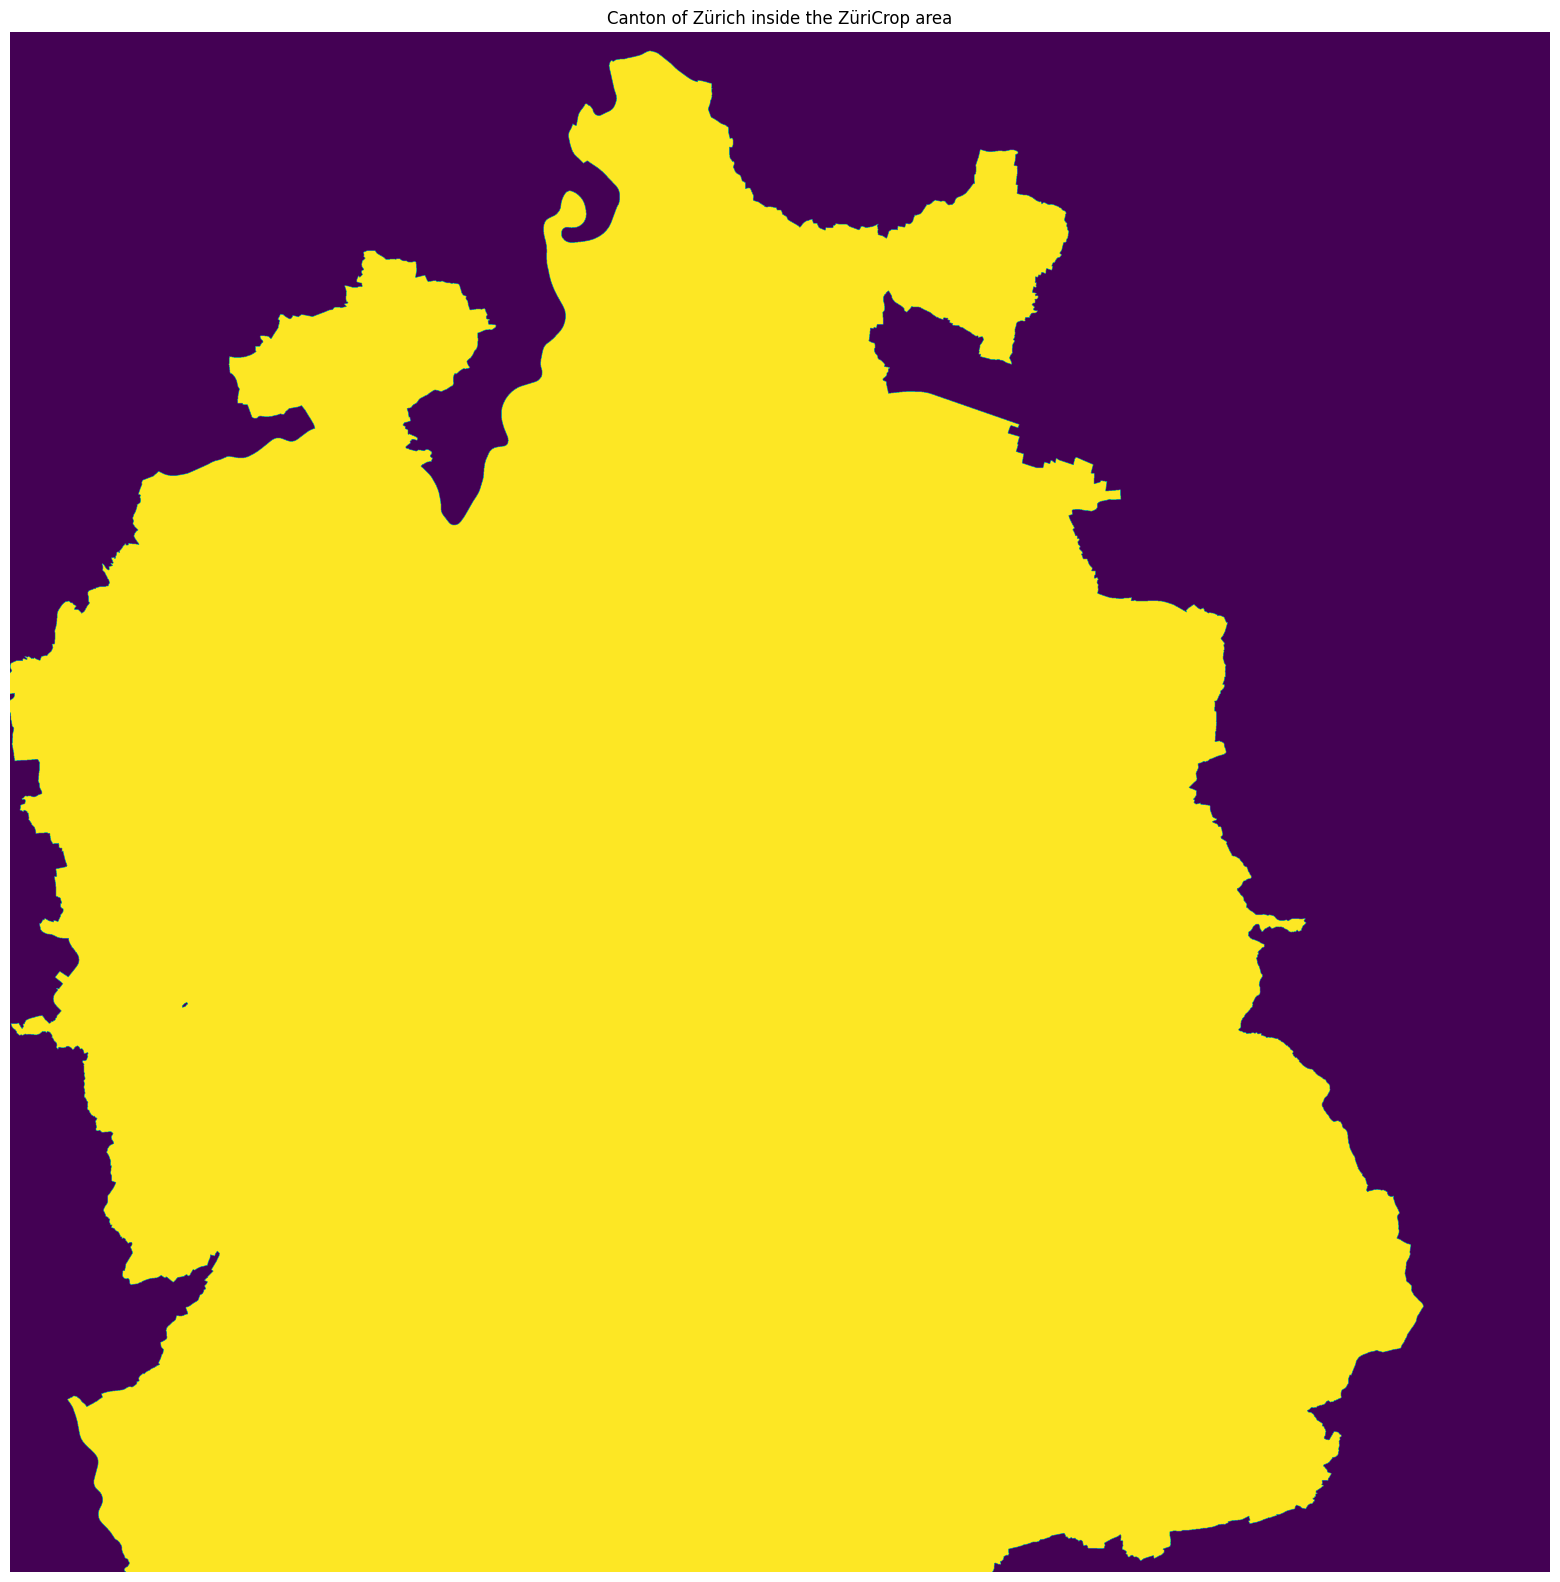

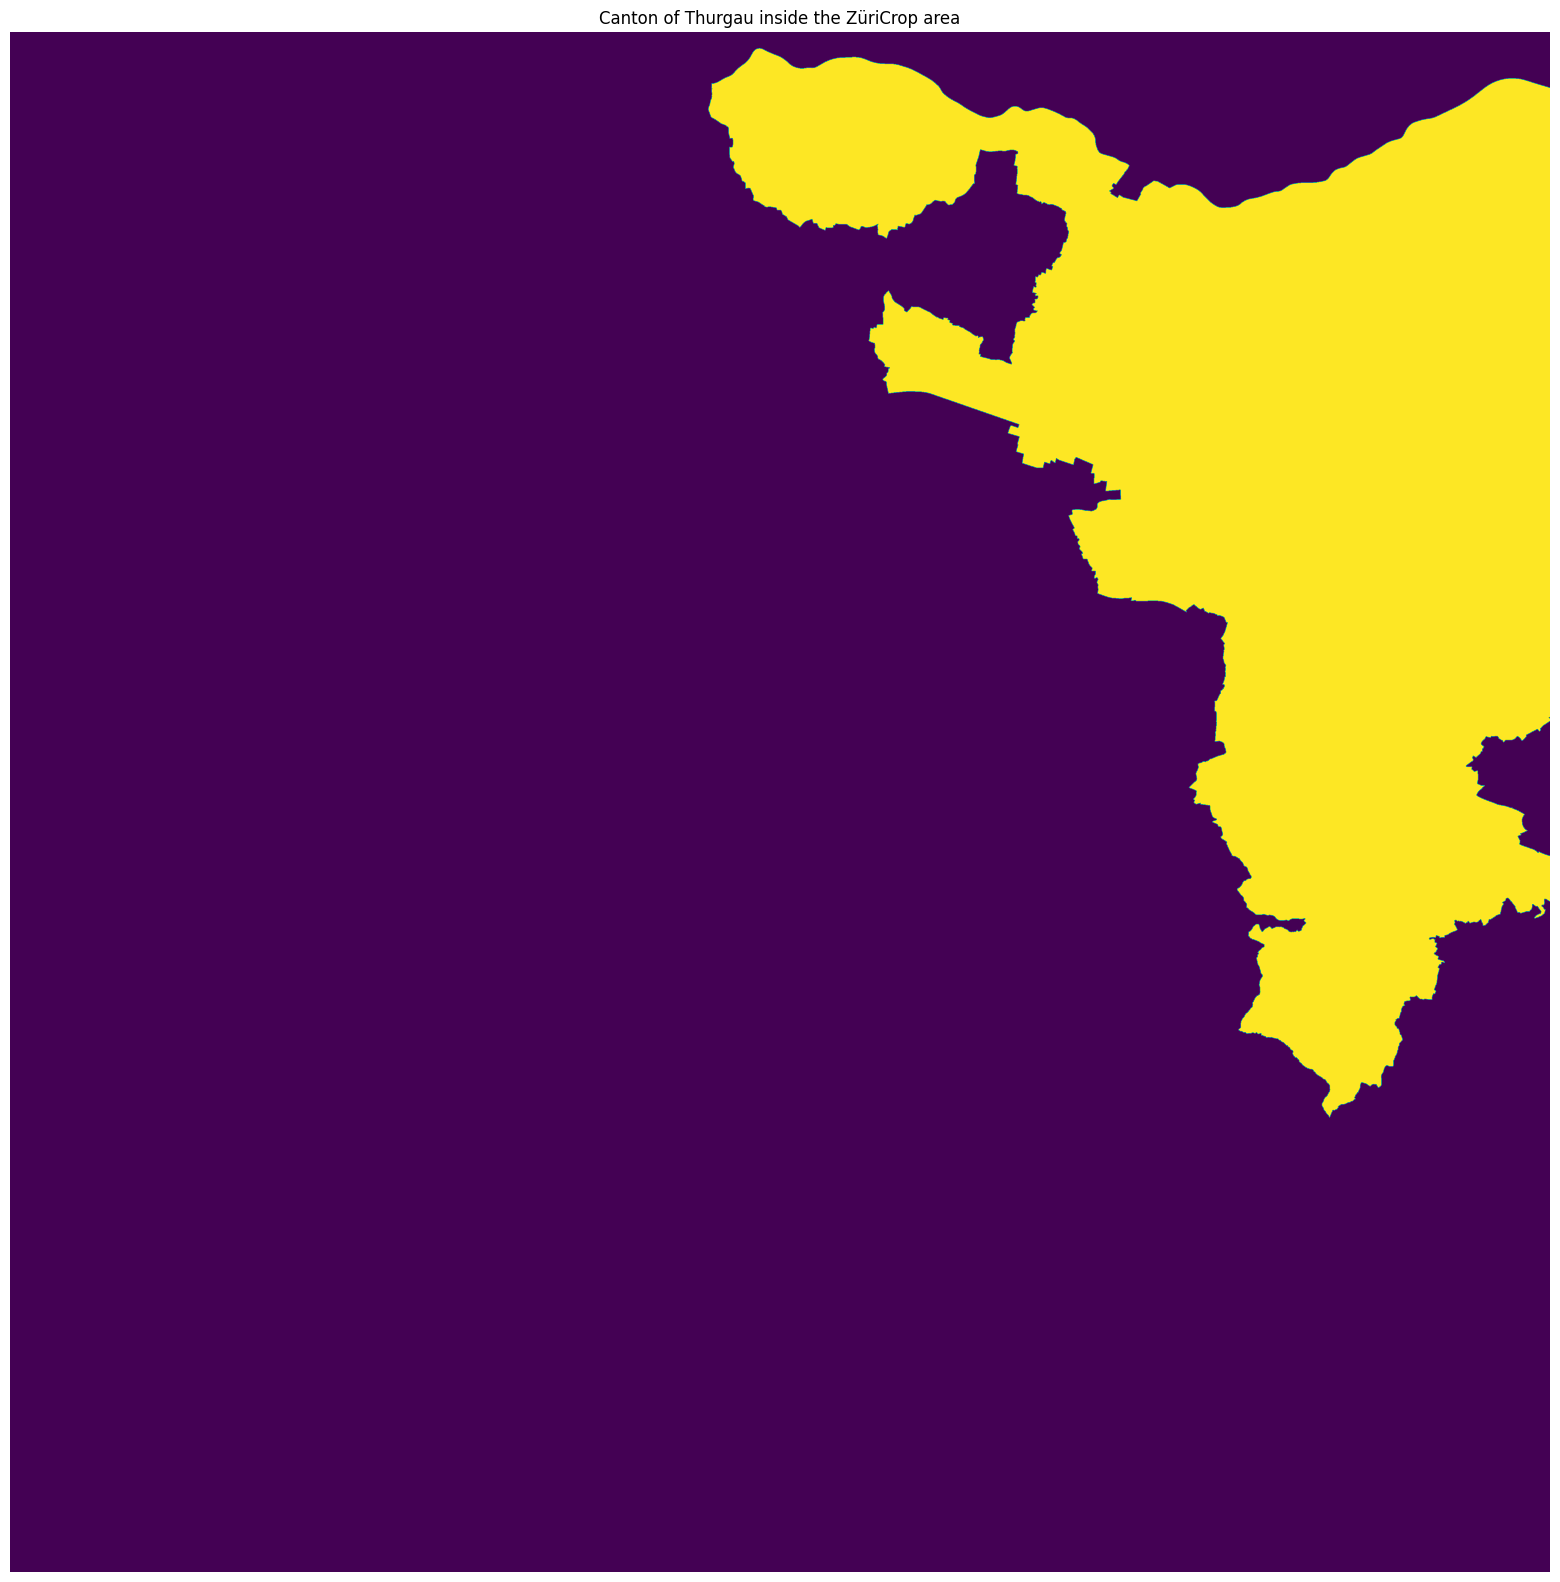

In [14]:
plt.figure(figsize=(20, 20))
plt.imshow(canton_zh_mask)
plt.axis('off')
plt.title("Canton of Zürich inside the ZüriCrop area")
plt.show()

plt.figure(figsize=(20, 20))
plt.imshow(canton_tg_mask)
plt.axis('off')
plt.title("Canton of Thurgau inside the ZüriCrop area")
plt.show()

In [15]:
canton_mask = np.sum(np.stack([canton_zh_mask, canton_tg_mask], axis=0), axis=0)
print(f"Number of pixels where cantons overlap: {np.sum(canton_mask == 2)}")

Number of pixels where cantons overlap: 0


great, this is as expected

let's check whether there are any overlaps inside both cantons

In [16]:
masks_zh = np.stack(list(masks_by_lnf_code_zh.values()), axis=0)
mask_zh_consolidated = np.sum(masks_zh, axis=0)
print(f"Highest number of overlapping polygons in Zürich: {mask_zh_consolidated.max()}")
print(f"Number of pixels overlapping in Zürich: {(mask_zh_consolidated > 1).sum()}")

Highest number of overlapping polygons in Zürich: 1
Number of pixels overlapping in Zürich: 0


In [17]:
masks_tg = np.stack(list(masks_by_lnf_code_tg.values()), axis=0)
mask_tg_consolidated = np.sum(masks_tg, axis=0)
print(f"Highest number of overlapping polygons in Thurgau: {mask_tg_consolidated.max()}")
print(f"Number of pixels overlapping in Thurgau: {(mask_tg_consolidated > 1).sum()}")

Highest number of overlapping polygons in Thurgau: 1
Number of pixels overlapping in Thurgau: 0


In [18]:
mask_consolidated = mask_tg_consolidated + mask_zh_consolidated
print(f"Highest number of overlapping polygons in both cantons: {mask_consolidated.max()}")
print(f"Number of pixels overlapping in both cantons: {(mask_consolidated > 1).sum()}")

Highest number of overlapping polygons in both cantons: 2
Number of pixels overlapping in both cantons: 110323


There are no overlapping areas inside each canton but certainly there are overlapping areas between the two cantons. So we just keep the data from each canton and merge them together.

In [19]:
labels = np.zeros((height, width), dtype=np.uint8)


for lnf_code, code in tqdm(lnf_code_mapping.items(), total=len(lnf_code_mapping)):
    if lnf_code not in masks_by_lnf_code_zh:
        continue

    lnf_mask = masks_by_lnf_code_zh[lnf_code] & canton_zh_mask

    if labels[lnf_mask].sum() > 0:
        raise ValueError(f"Mask for lnf_code {lnf_code} is not empty")

    labels[lnf_mask] = np.uint8(code)


for lnf_code, code in tqdm(lnf_code_mapping.items(), total=len(lnf_code_mapping)):
    if lnf_code not in masks_by_lnf_code_tg:
        continue

    lnf_mask = masks_by_lnf_code_tg[lnf_code] & canton_tg_mask
    
    if labels[lnf_mask].sum() > 0:
        raise ValueError(f"Mask for lnf_code {lnf_code} is not empty")
    
    labels[lnf_mask] = np.uint8(code)

100%|██████████| 80/80 [00:00<00:00, 127.55it/s]


In [20]:
with rasterio.open(params['paths']['labels'], 'w', driver='GTiff', 
                   width=width, height=height, 
                   count=1, dtype=rasterio.uint8,
                   crs=crs, transform=transform) as dst:
    dst.write(labels, 1)

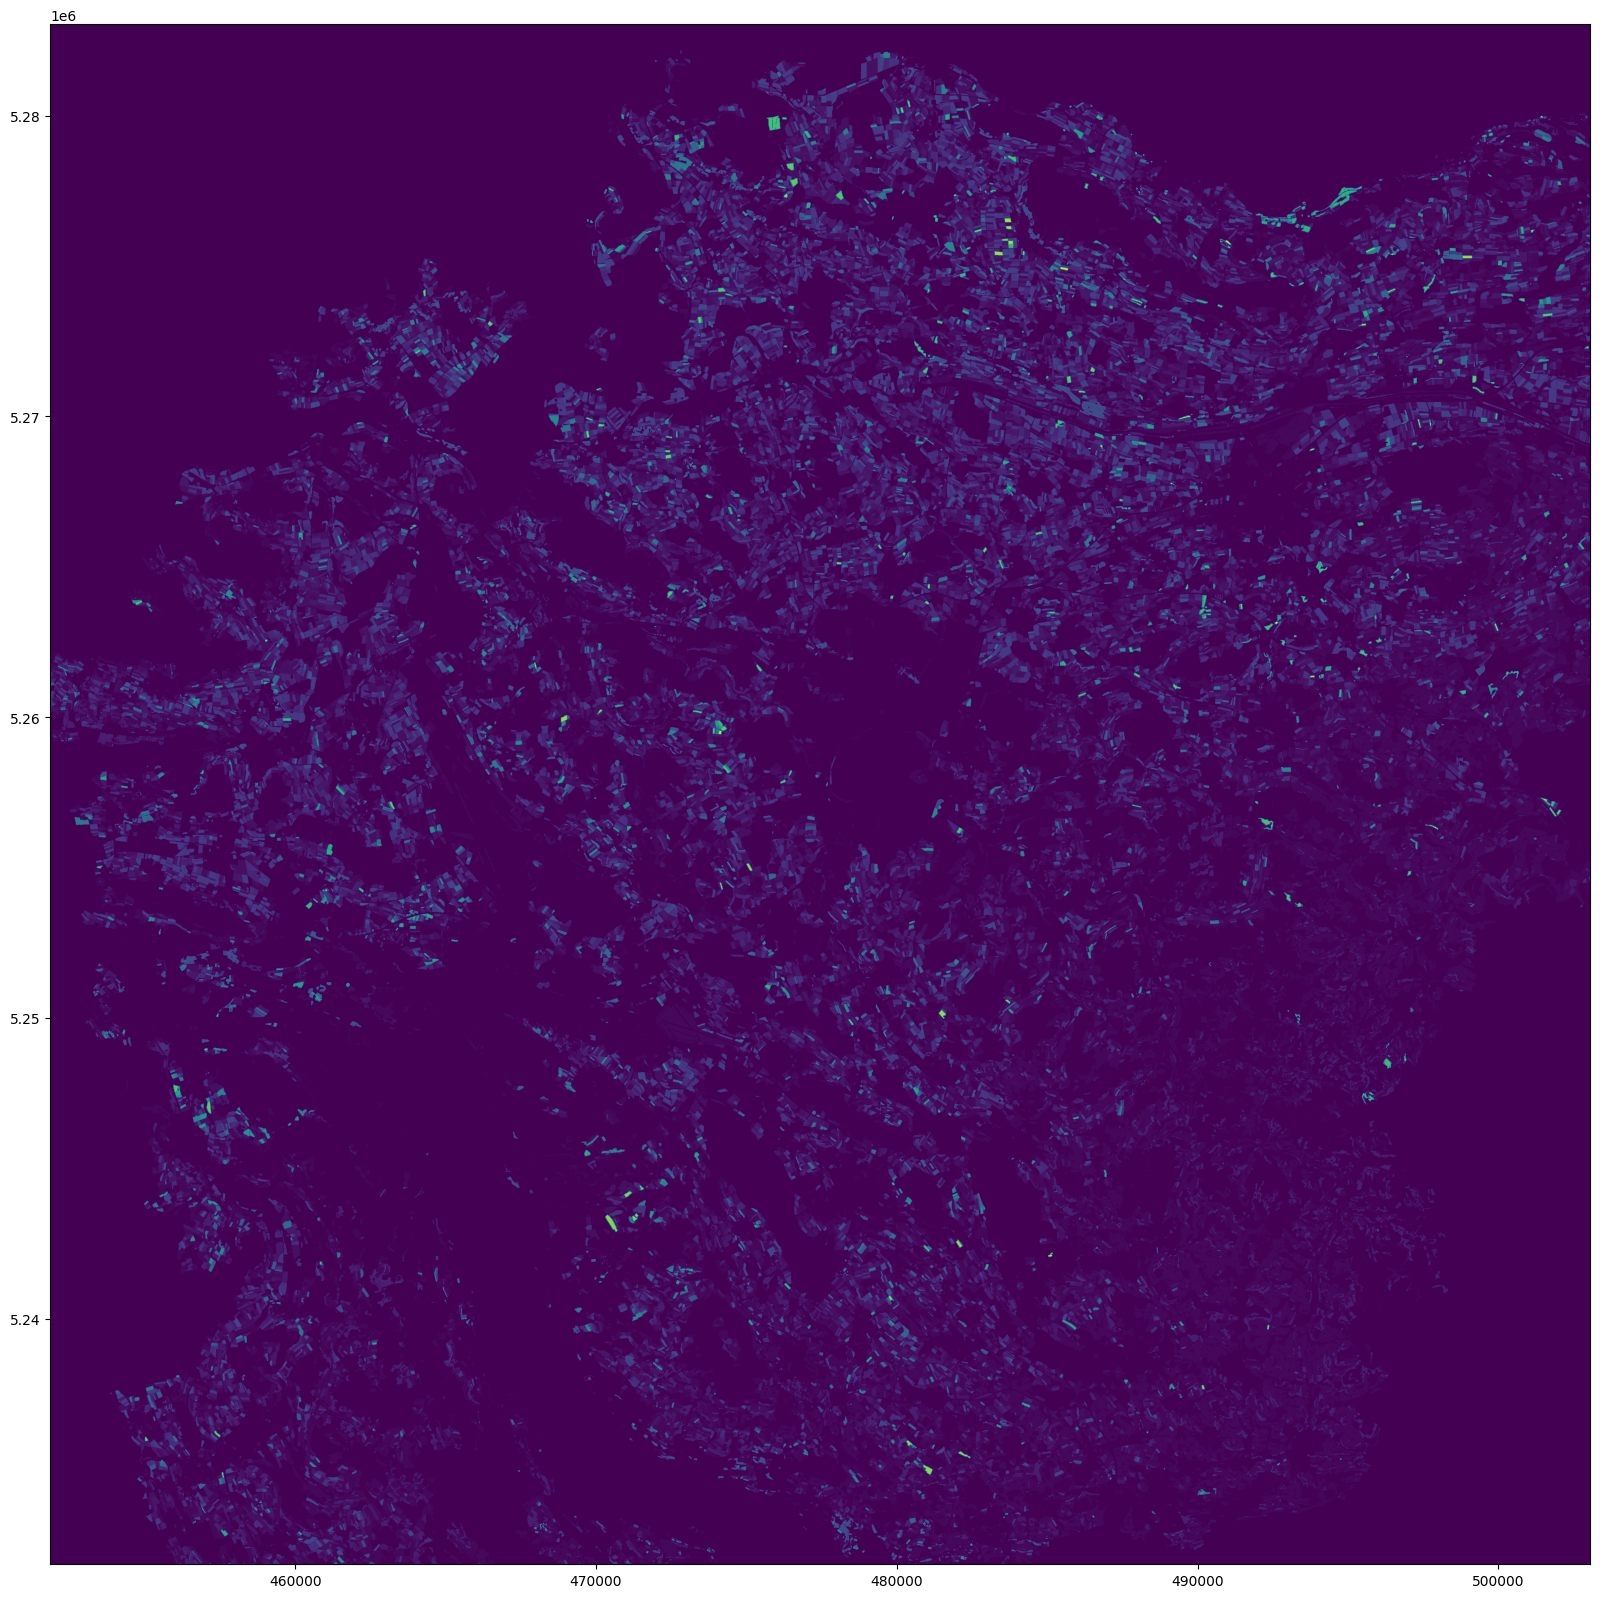

In [21]:
with rasterio.open(params['paths']['labels']) as src:
    plt.figure(figsize=(20, 20))
    show(src, cmap='viridis')
    plt.show()

## Hierarchy Labels

In [22]:
if params['label_hierarchy_definition'] == 'zueri_crop':
    print(labels_zueri_crop[[
        'tier_1',
        'tier_2',
        'tier_3',
        'tier_4',
        ]].nunique())
elif params['label_hierarchy_definition'] == 'seasonality':
    print(labels_zueri_crop[[
        'tier_1',
        'tier_2',
        'tier_3',
        ]].nunique())

tier_1     1
tier_2     5
tier_3    16
tier_4    48
dtype: int64


The first level tier is comprised of `['Vegetation' 'Bare soil' 'Infrastructure' nan 'Undefined']` and is ignored in the _Crop mapping from image time series: Deep learning with multiscale label hierarchies_ paper. We therefore ignore it too.

In [23]:
if params['label_hierarchy_definition'] == 'zueri_crop':
    tier_columns = ['tier_2', 'tier_3', 'tier_4']
elif params['label_hierarchy_definition'] == 'seasonality':
    tier_columns = ['tier_2', 'tier_3']

tier_mappings = {} # maps names to integers for each tier
for column in tier_columns:
    tier_mappings[column] = {name: i+1 for i, name in enumerate(labels_zueri_crop[column].unique())}

print(tier_mappings)

{'tier_2': {'Grassland': 1, 'Field crops': 2, 'Orchards': 3, 'Special crops': 4, 'Forest': 5}, 'tier_3': {'Meadow': 1, 'SmallGrainCereal': 2, 'LargeGrainCereal': 3, 'Pasture': 4, 'BroadLeafRowCrop': 5, 'VegetableCrop': 6, 'OrchardCrop': 7, 'Fallow': 8, 'Hedge': 9, 'Berries': 10, 'TreeCrop': 11, 'CropMix': 12, 'BiodiversityArea': 13, 'Forest': 14, 'Multiple': 15, 'Gardens': 16}, 'tier_4': {'Meadow': 1, 'WinterWheat': 2, 'Maize': 3, 'Pasture': 4, 'Sugar_beets': 5, 'WinterBarley': 6, 'WinterRapeseed': 7, 'Vegetables': 8, 'Potatoes': 9, 'Wheat': 10, 'Sunflowers': 11, 'Vines': 12, 'Spelt': 13, 'Fallow': 14, 'Hedge': 15, 'Apples': 16, 'Soy': 17, 'Peas': 18, 'Oat': 19, 'Berries': 20, 'EinkornWheat': 21, 'Field bean': 22, 'SummerWheat': 23, 'Rye': 24, 'TreeCrop': 25, 'StoneFruit': 26, 'MixedCrop': 27, 'Sorghum': 28, 'Grain': 29, 'Chicory': 30, 'Pears': 31, 'SummerBarley': 32, 'Biodiversity encouragement area': 33, 'Forest': 34, 'Linen': 35, 'Legumes': 36, 'Pumpkin': 37, 'Tobacco': 38, 'Buckwhe

In [24]:
print(f"Mapping for lnf code 501: {lnf_code_mapping[501]}")
print(f"Min mapping value: {min(lnf_code_mapping.values())}")
print(f"Max mapping value: {max(lnf_code_mapping.values())}")

Mapping for lnf code 501: 32
Min mapping value: 1
Max mapping value: 48


In [25]:
# N Channels based on the number of tiers in the labels hierarchy
n_tiers = len(tier_columns)
labels_hierarchy = np.zeros((height, width, 3), dtype=np.uint8)
print(f"Number of channels in {params['label_hierarchy_definition']} label hierarchy: {n_tiers}")

# map the integers from labels.tif to the integers defined in the tier_mappings for each tier 
hierarchy_mapping = {tier: {code: np.uint8(tier_mappings[tier][name]) for code, name in zip(labels_zueri_crop['index'], labels_zueri_crop[tier])} for tier in tier_columns}

# add a zero lnf code mappings for the background
for tier in tier_columns:
    print(f"Tier: {tier}")
    hierarchy_mapping[tier][0] = np.uint8(0)

Number of channels in zueri_crop label hierarchy: 3
Tier: tier_2
Tier: tier_3
Tier: tier_4


In [26]:
for tier in tier_columns:
    print(f"Tier: {tier}")
    labels_hierarchy[..., tier_columns.index(tier)] = np.vectorize(hierarchy_mapping[tier].get)(labels)

Tier: tier_2
Tier: tier_3
Tier: tier_4


In [27]:
for tier in tier_columns:
    print(f"Tier: {tier}")
    print(f"Number of unique values in the {tier}: {np.unique(labels_hierarchy[..., tier_columns.index(tier)])}")
    print(f"min value in the {tier}: {np.min(labels_hierarchy[..., tier_columns.index(tier)])}")
    print(f"max value in the {tier}: {np.max(labels_hierarchy[..., tier_columns.index(tier)])}")
    print()

Tier: tier_2
Number of unique values in the tier_2: [0 1 2 3 4 5]
min value in the tier_2: 0
max value in the tier_2: 5

Tier: tier_3
Number of unique values in the tier_3: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
min value in the tier_3: 0
max value in the tier_3: 16

Tier: tier_4
Number of unique values in the tier_4: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48]
min value in the tier_4: 0
max value in the tier_4: 48



This looks good👍🏻. Save this meta information for later use in the evaluation of the model.

In [28]:
reverse_tier_mappings = {tier: {v: k for k, v in tier_mappings[tier].items()} for tier in tier_columns}

tier_names = {tier: [reverse_tier_mappings[tier][i] for i in range(1, len(reverse_tier_mappings[tier])+1)] for tier in tier_columns}

# add category "background" at the beginning
for tier in tier_columns:
    tier_names[tier].insert(0, "Background")

# replace tier names such that they're compatible with tiers used in the model
# decrement the number by 1
dataset_info = dict()
for i, tier in enumerate(tier_columns, start=1):
    dataset_info[f"tier{i}"] = tier_names[tier]

map_new_to_old_tier_names = {f"tier{i}": tier for i, tier in enumerate(tier_columns, start=1)}
map_old_to_new_tier_names = {v: k for k, v in map_new_to_old_tier_names.items()}
print(f"New to old tier names mapping: {map_new_to_old_tier_names}")

# order dict by key
dataset_info = dict(sorted(dataset_info.items()))

New to old tier names mapping: {'tier1': 'tier_2', 'tier2': 'tier_3', 'tier3': 'tier_4'}


In [29]:
# save a mapping of the int from the last tier (e.g. tier_3) to each previous tier (e.g. tier_2, tier_1)
new_tier_names = list(dataset_info.keys())
last_tier = new_tier_names[-1]
previous_tiers = new_tier_names[:-1]
print(f"Last tier: {last_tier} | Previous tiers: {previous_tiers}")

for tier in previous_tiers:
    old_tier_name = map_new_to_old_tier_names[tier]
    tier_to_prev_tier = [0] * (max(hierarchy_mapping[old_tier_name].keys()) + 1)
    for k, v in hierarchy_mapping[old_tier_name].items():
        tier_to_prev_tier[k] = int(v)
    dataset_info[last_tier + "_to_" + tier] = tier_to_prev_tier

Last tier: tier3 | Previous tiers: ['tier1', 'tier2']


In [30]:
with open(params['paths']['dataset_info'], 'w') as f:
    json.dump(dataset_info, f, indent=4)

In [31]:
dataset_info

{'tier1': ['Background',
  'Grassland',
  'Field crops',
  'Orchards',
  'Special crops',
  'Forest'],
 'tier2': ['Background',
  'Meadow',
  'SmallGrainCereal',
  'LargeGrainCereal',
  'Pasture',
  'BroadLeafRowCrop',
  'VegetableCrop',
  'OrchardCrop',
  'Fallow',
  'Hedge',
  'Berries',
  'TreeCrop',
  'CropMix',
  'BiodiversityArea',
  'Forest',
  'Multiple',
  'Gardens'],
 'tier3': ['Background',
  'Meadow',
  'WinterWheat',
  'Maize',
  'Pasture',
  'Sugar_beets',
  'WinterBarley',
  'WinterRapeseed',
  'Vegetables',
  'Potatoes',
  'Wheat',
  'Sunflowers',
  'Vines',
  'Spelt',
  'Fallow',
  'Hedge',
  'Apples',
  'Soy',
  'Peas',
  'Oat',
  'Berries',
  'EinkornWheat',
  'Field bean',
  'SummerWheat',
  'Rye',
  'TreeCrop',
  'StoneFruit',
  'MixedCrop',
  'Sorghum',
  'Grain',
  'Chicory',
  'Pears',
  'SummerBarley',
  'Biodiversity encouragement area',
  'Forest',
  'Linen',
  'Legumes',
  'Pumpkin',
  'Tobacco',
  'Buckwheat',
  'Hemp',
  'SummerRapeseed',
  'Hops',
  'Beet

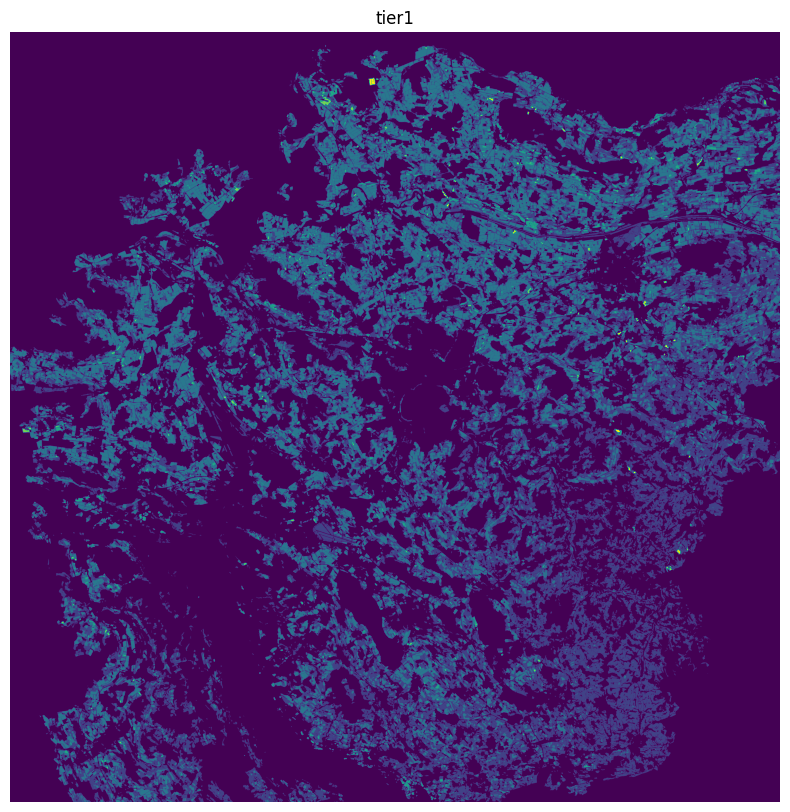

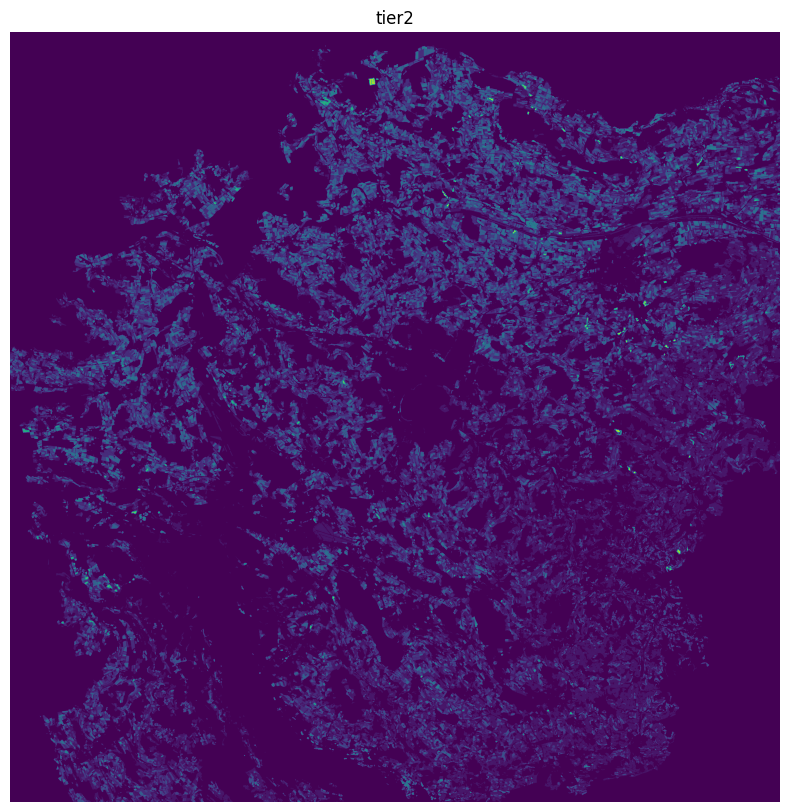

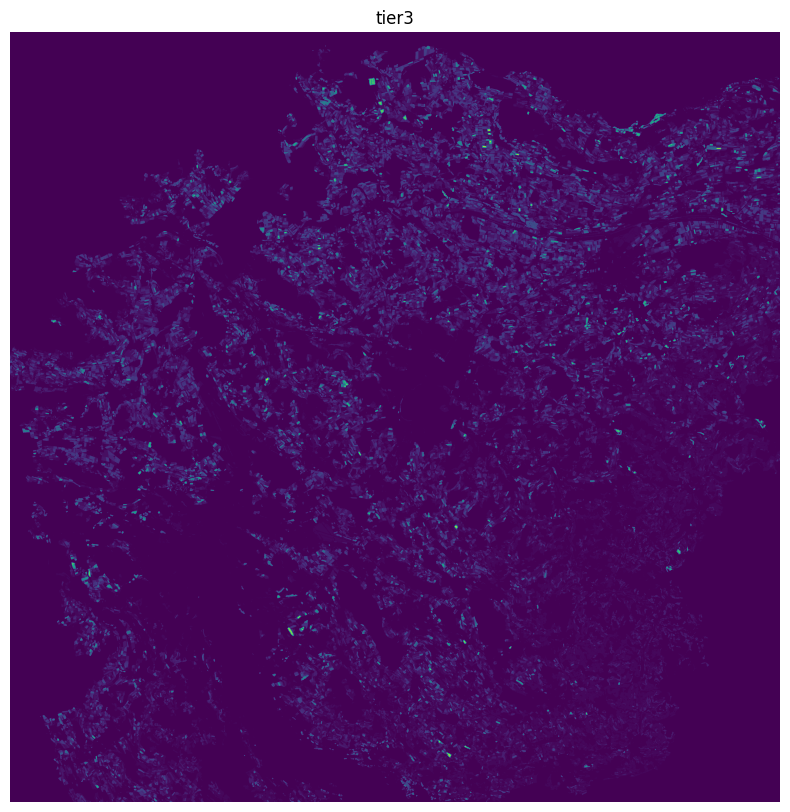

In [32]:
for tier in tier_columns:
    new_tier_name = map_old_to_new_tier_names[tier]
    plt.figure(figsize=(10, 10))
    plt.imshow(labels_hierarchy[..., tier_columns.index(tier)], cmap='viridis')
    plt.axis('off')
    plt.title(new_tier_name)
    plt.show()

In [33]:
# Save the labels hierarchy (number of tiers defines the number of channels)
with rasterio.open(params['paths']['labels_hierarchy'], 'w', driver='GTiff', 
                   width=width, height=height, 
                   count=n_tiers, dtype=rasterio.uint8,
                   crs=crs, transform=transform) as dst:
    for i in range(n_tiers):
        dst.write(labels_hierarchy[..., i], i+1)

# Create GeoTIFF with field labels

In [34]:
field_ids = np.zeros((height, width), dtype=np.uint32)

gdf_crs = gdf.to_crs(crs)

gdf_crs_zh = gdf_crs[gdf_crs['zh_id'].notnull()]
shapes_zh = ((geom, index) for index, geom in zip(gdf_crs_zh['index'], gdf_crs_zh['geometry']))
field_ids_zh = rasterio.features.rasterize(shapes_zh, out_shape=(height, width), fill=0, all_touched=False, transform=transform, dtype=np.uint32)
field_ids_zh[~canton_zh_mask] = 0

gdf_crs_tg = gdf_crs[gdf_crs['tg_id'].notnull()]
shapes_tg = ((geom, index) for index, geom in zip(gdf_crs_tg['index'], gdf_crs_tg['geometry']))
field_ids_tg = rasterio.features.rasterize(shapes_tg, out_shape=(height, width), fill=0, all_touched=False, transform=transform, dtype=np.uint32)
field_ids_tg[~canton_tg_mask] = 0

In [35]:
field_ids_consolidated = (field_ids_zh > 0) + (field_ids_tg > 0)
print(f"Number of fields: {np.sum(field_ids_consolidated > 0)}")
print(f"Number of fields in Zürich: {np.sum(field_ids_zh > 0)}")
print(f"Number of fields in Thurgau: {np.sum(field_ids_tg > 0)}")
print(f"Number of overlapping fields: {np.sum(field_ids_consolidated > 1)}")

Number of fields: 8528949
Number of fields in Zürich: 6124612
Number of fields in Thurgau: 2404337
Number of overlapping fields: 0


Great, no overlapping fields between the two cantons. We can now safely merge the two datasets together.

In [36]:
field_ids = field_ids_zh + field_ids_tg

print(f"Min and max field ID: {field_ids.min()}, {field_ids.max()}")

Min and max field ID: 0, 102147


In [37]:
with rasterio.open(params['paths']['field_ids'], 'w', driver='GTiff', 
                   width=width, height=height, 
                   count=1, dtype=rasterio.uint32,
                   crs=crs, transform=transform) as dst:
    dst.write(field_ids, 1)